In [1]:
import torch; torch.manual_seed(0)
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader,random_split
from function.Dir import Dir
from function.ssim_torch import ssim_function
from function.jsdiv import jsdiv,jsdiv_single
from function.Dataset import ImageDataset
from function.Loss import Custom_criterion
from function.Log import log
import torch.nn.functional as F
import importlib

EXP_NAME = "EXP_0_1"
MODEL_NAME = 'CNN'
traintype = 'poissonsrc+bkg'
EPOCHS = 400 #参数1

Model_module = importlib.import_module(f'function.{MODEL_NAME}_{EXP_NAME}')
Model = getattr(Model_module, MODEL_NAME)

filepath = "/root/autodl-fs/SimulatedData/norandPSF_6.4x6.4_Poisson.npy"
#filepath = "/root/autodl-fs/SimulatedData/GaussianSRC_tx.npy"
savefigname = 'CNN_400epo_lhasao'
filetmp = np.load(filepath,allow_pickle=True)
filelen = filetmp.shape[0]
del filetmp
frac_train = 0.8
NUM_TO_LEARN = int(filelen*frac_train) #训练集放入图片对数量
NUM_TO_TEST = int(filelen*(1-frac_train))


BATCH_SIZE = 32 #参数2
LATENTDIM = 64 #参数3
LR_MAX = 5e-4
LR_MIN = 5e-6
mode = 1 #0代表STED_HC文件训练，1代表使用STED，对应ImageDataset里的 mode 参数。（STED出的模型对泛化能力弱，STED_HC对训练集的还原会有点失真）

DEVICE = 'cuda'
LOSS_PLOT = []
TESTLOSS_PLOT = []
EPOCH_PLOT = []

In [2]:
name = f'{EPOCHS}epo_{BATCH_SIZE}bth_{LATENTDIM}latn_{traintype}'

#加载数据集
dataset = ImageDataset(NUM_TO_LEARN, mode,filepath)
trainset, testset = random_split(dataset,
                                            lengths=[int(frac_train *len(dataset)),
                                            len(dataset) - int(frac_train * len(dataset))],
                                            generator=torch.Generator().manual_seed(0))

dataloader = DataLoader(trainset,shuffle=True,batch_size=BATCH_SIZE)
testloader = DataLoader(testset,shuffle=False,batch_size=BATCH_SIZE)

#初始化Model网络
model = Model(LATENTDIM).to(DEVICE)
model.load_state_dict(torch.load(f'../models/{MODEL_NAME}_{EXP_NAME}_model_{name}.pth',weights_only=True))
#model.load_state_dict(torch.load(f'../models/{EXP_NAME}_model_{name}.pth',weights_only=True))

#model.reset_parameters()
#model = nn.DataParallel(model) #将 Model 包装成一个并行化模型，以便在多个 GPU 上并行地进行训练

#定义LOSS函数与优化器
lossfunction = jsdiv
#optimizer = torch.optim.AdamW(model.parameters(), lr = LR_MAX)

In [3]:
# 打印数据集中的一些样本
for batch_idx, (blurry_img, original_img) in enumerate(testloader):
    continue
    print(f"Batch {batch_idx + 1}:")
    print(f"Blurry image shape: {blurry_img.shape}")
    print(f"Original image shape: {original_img.shape}")
blurry_img_numpy = blurry_img[1].squeeze().detach().numpy()
print(blurry_img_numpy.min())
print(blurry_img_numpy.max())
print(blurry_img_numpy)

0.0
1.0
[[0.07042254 0.05633803 0.11267605 ... 0.05633803 0.02816901 0.07042254]
 [0.04225352 0.02816901 0.09859155 ... 0.05633803 0.07042254 0.02816901]
 [0.09859155 0.05633803 0.07042254 ... 0.07042254 0.04225352 0.04225352]
 ...
 [0.05633803 0.05633803 0.07042254 ... 0.04225352 0.09859155 0.07042254]
 [0.05633803 0.04225352 0.04225352 ... 0.11267605 0.07042254 0.08450704]
 [0.02816901 0.11267605 0.02816901 ... 0.08450704 0.02816901 0.05633803]]


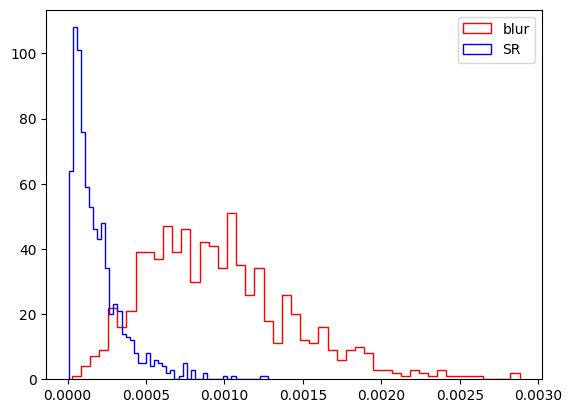

In [4]:
import sys 
sys.path.append('./function/')
from ssim_torch import ssim_function_valid

model.cpu()
LOSS_SR = np.array([])
LOSS_BLU = np.array([])
valid_lossf = jsdiv_single#ssim_function_valid
for batch_idx, (blurry_img, original_img) in enumerate(testloader):
    img_sr,jpt,jpt = model(blurry_img.detach())
    loss_sr = valid_lossf(img_sr,original_img).detach().cpu().numpy()
    loss_blurry = valid_lossf(blurry_img,original_img).detach().numpy()
    LOSS_SR = np.concat((LOSS_SR,loss_sr.flatten()))
    LOSS_BLU = np.concat((LOSS_BLU,loss_blurry.flatten()))
    #print(loss_sr.shape)

def hist(arr,color,nbins = 50,histtype = 'step',label = 'label'):
    #bins = np.logspace(np.log10(arr.min()),np.log10(arr.max()),nbins)
    #jpt = plt.hist(arr,bins = bins,density=True,histtype = histtype,color =color)
    #plt.xscale('log')
    bins = np.linspace((arr.min()),(arr.max()),nbins)
    jpt = plt.hist(arr,bins = bins,density=False,histtype = histtype,color =color,label = label)
    plt.legend()

plt.figure()
hist(LOSS_BLU,'red',label = 'blur')
hist(LOSS_SR,'blue',label = 'SR')
#plt.xlim(0,0.002)
plt.savefig('/root/autodl-fs/Plots/%s_jsdiv.png'%savefigname,dpi=300)




/tmp/ipykernel_1807/2848559650.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


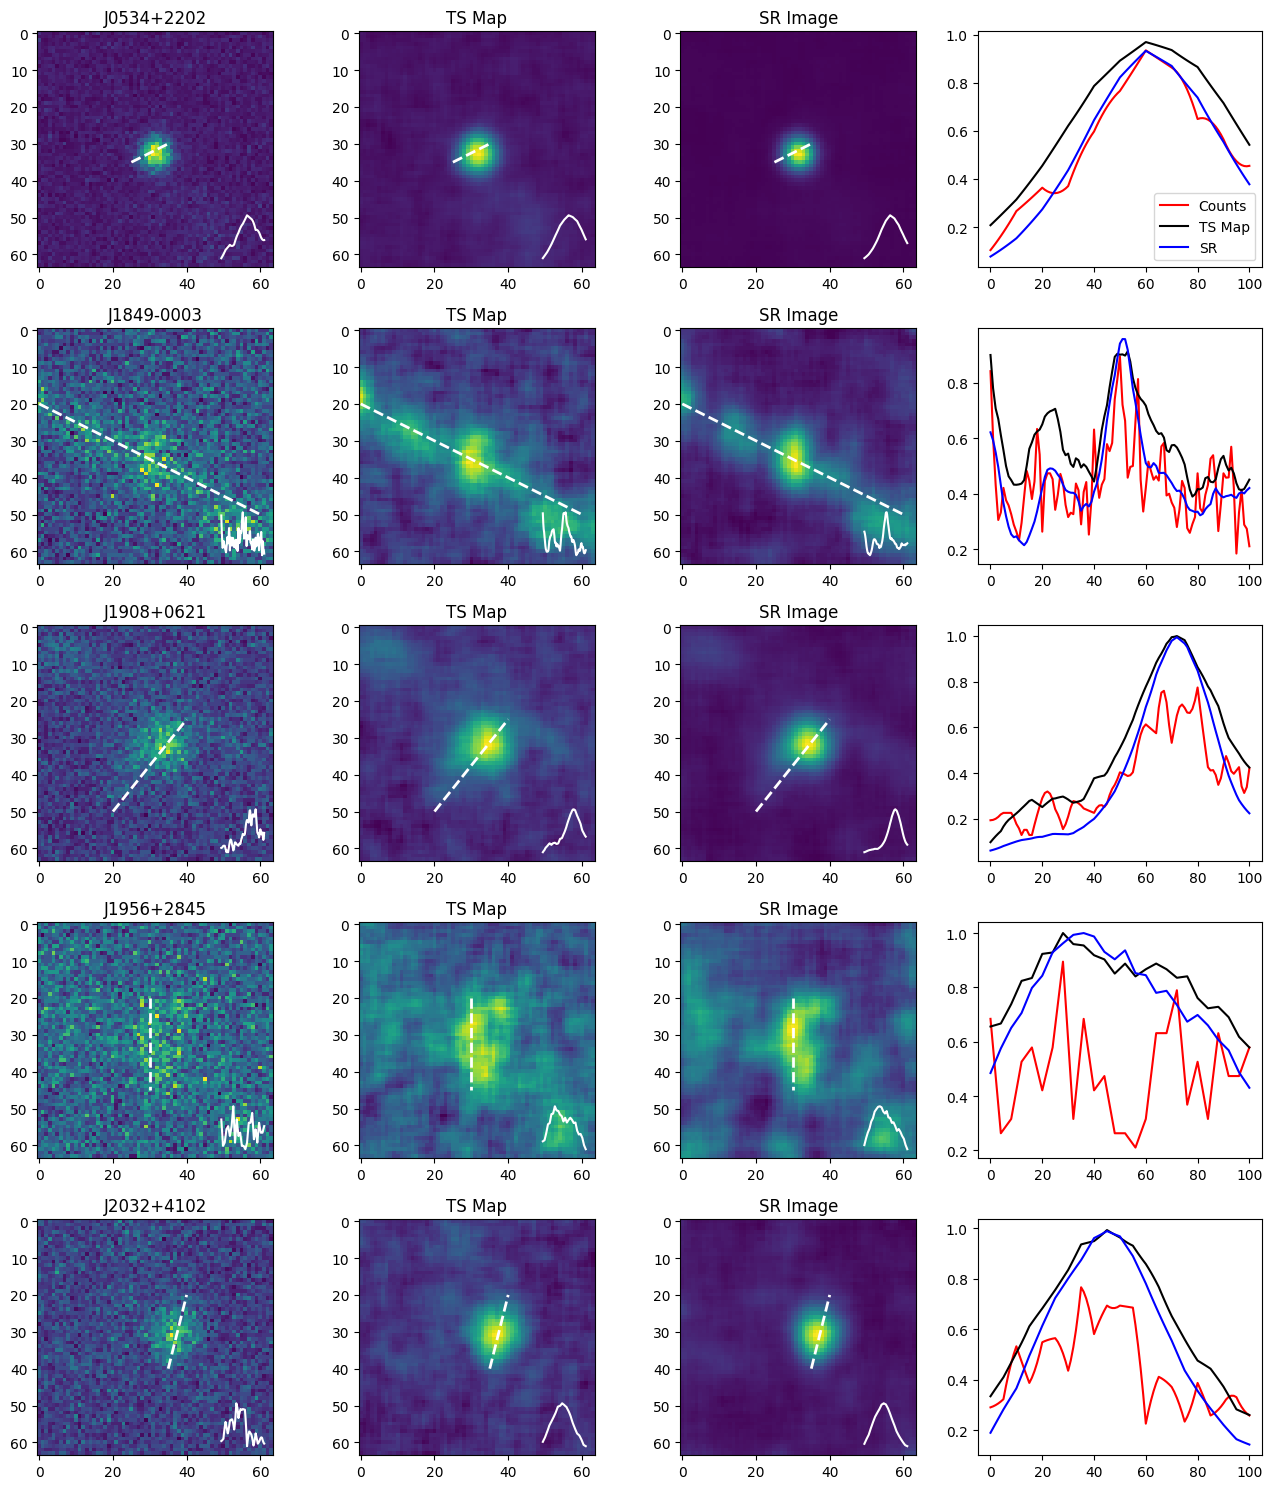

In [23]:
import torch
import matplotlib.pyplot as plt
import scipy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
num_images_to_show = 10

def interp2d(x1,x2,y1,y2,arr):
    x = np.arange(arr.shape[0])
    y = np.arange(arr.shape[0])
    xx,yy = np.meshgrid(x,y)
    interpolate = scipy.interpolate.RegularGridInterpolator((x,y),arr)
    y_t = np.linspace(x1,x2,101)
    x_t = np.linspace(y1,y2,101)
    z_t = interpolate((x_t,y_t))
    return z_t

model.eval()  # 切换到评估模式
model.to(DEVICE)

img_LR=[] 
#img_HR=[]
img_SR=[]

showlist = [0,1,2,3,4]
num_images_to_show = len(showlist)

hons = np.load('/root/autodl-fs/SimulatedData/LHAASO_DATA.npy',allow_pickle=True)
tsmaps = np.load('/root/autodl-fs/SimulatedData/LHAASO_DATA_TSMap.npy',allow_pickle=True)
lhaaso_filelist = np.loadtxt('/root/autodl-fs/SimulatedData/filelist_lhaaso',dtype=object)

for i in showlist:
    hon = hons[i]
    item = torch.tensor((hon-hon.min())/(hon.max()-hon.min()),dtype=torch.float).unsqueeze(0)
    img_LR.append(item)
    #img_TS.append((tsmaps[i]-tsmaps[i].min())/(tsmaps[i].max()-tsmaps[i].min()))
    img_SR.append(model((item.reshape(1,1,64,64).to(DEVICE)))[0].cpu())
    
#for _, (img_LR, img_HR) in enumerate(testloader):
#    #print(img_LR.shape)
#    img_SR, _, _ = model(img_LR.to(DEVICE))
#    img_SR = img_SR.cpu()
#    break


# 创建一个包含三列的图像网格，每一列显示一张模糊图像、超分辨率图像和原始图像
fig, axes = plt.subplots(num_images_to_show,4 , figsize=(13, 3 * num_images_to_show))

xys = np.zeros(num_images_to_show).tolist()
for i in range(num_images_to_show):
    xys[i] = [0,0,0,0]

#txdata
#xys[0] = [35,45,55,35]
#xys[1]=[25,45,45,60]

#poisson
xys[0] = [25,35,35,30]
xys[1]=[0,60,20,50]
xys[2]=[20,40,50,25]
xys[3]=[30,30,20,45]
xys[4]=[35,40,40,20]

#randpsfdata
#xys[0] = [0,20,0,15]
#xys[1]=[20,55,45,25]

def minmax(arr):
    return (arr-arr.min())/(arr.max()-arr.min())

# 遍历每个样本
for i in range(num_images_to_show):
    color = 'white'
    x1,x2,y1,y2 = xys[i]
    # 获取模糊图像、超分辨率图像和原始图像
    blurry_img_numpy = img_LR[i].squeeze().detach().cpu().numpy()
    sr_img_numpy = minmax(img_SR[i].squeeze().detach().cpu().numpy())
    ts_img_numpy = minmax(tsmaps[i])#/tsmaps[i].sum()#(tsmaps[i]-tsmaps[i].min())/(tsmaps[i].max()-tsmaps[i].min())
    #blurry_img_numpy =minmax(blurry_img_numpy)#/blurry_img_numpy.sum()
    blurry_img_numpy = minmax(hons[i])#/hons[i].sum()
    #original_img_numpy=original_img_numpy/original_img_numpy.sum()
    sr_img_numpy =sr_img_numpy#/sr_img_numpy.sum() 
    
    # 显示模糊图像
    im0=axes[i, 0].imshow(blurry_img_numpy)
    axes[i, 0].set_title(lhaaso_filelist[i][-18:-8])
    #axes[i, 0].axis('off')
    axes[i,0].plot([x1,x2],[y1,y2],linestyle='--',color =color,linewidth = 2)
    #-----------
    axins = inset_axes(axes[i,0], width="20%", height="20%", loc=4)
    axins.axis('off')
    axins.patch.set_alpha(0)
    axins.plot(interp2d(x1,x2,y1,y2,blurry_img_numpy),color=color)
    axes[i,-1].plot(interp2d(x1,x2,y1,y2,blurry_img_numpy),color = 'red',label='Counts')

    # 显示模糊图像
    im0=axes[i, 1].imshow(ts_img_numpy)
    axes[i,1].set_title('TS Map')
    #axes[i, 0].axis('off')
    axes[i,1].plot([x1,x2],[y1,y2],linestyle='--',color =color,linewidth = 2)
    #-----------
    axins = inset_axes(axes[i,1], width="20%", height="20%", loc=4)
    axins.axis('off')
    axins.patch.set_alpha(0)
    axins.plot(interp2d(x1,x2,y1,y2,ts_img_numpy),color=color)
    axes[i,-1].plot(interp2d(x1,x2,y1,y2,ts_img_numpy),color = 'black',label='TS Map')

    # 显示超分辨率图像
    im1=axes[i, 2].imshow(sr_img_numpy)
    axes[i, 2].set_title('SR Image')
    #axes[i, 1].axis('off')
    axes[i,2].plot([x1,x2],[y1,y2],linestyle='--',color = color,linewidth = 2)
    #-----------
    axins = inset_axes(axes[i,2], width="20%", height="20%", loc=4)
    axins.axis('off')
    axins.patch.set_alpha(0)
    axins.plot(interp2d(x1,x2,y1,y2,sr_img_numpy),color=color)
    axes[i,-1].plot(interp2d(x1,x2,y1,y2,sr_img_numpy),color = 'blue',label='SR')

axes[0,-1].legend()

# 调整子图之间的间距
plt.tight_layout()

# 显示图像
#fig.tight_layout()
plt.show()
fig.savefig('/root/autodl-fs/Plots/%s_figshow.png'%savefigname,dpi=300)


In [15]:
#((tsmaps[i]-tsmaps[i].min())/(tsmaps[i].max()-tsmaps[i].min())).max()
img_LR[0].max()

tensor(1.)